!pip install medmnist

# Medical Image Classification with MONAI

!pip install -q "monai-weekly[pillow, tqdm]"
!pip install -q matplotlib
%matplotlib inline

!pip install monai[all]

In [21]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet18
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.4
Pytorch version: 2.0.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: c:\Users\<username>\anaconda3\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.0
scikit-image version: 0.19.2
scipy version: 1.9.1
Pillow version: 9.2.0
Tensorboard version: 2.12.3
gdown version: 4.7.1
TorchVision version: 0.15.1+cpu
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional d

## Continue working with OrganMNIST3d 64x64x64

In [77]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d_64.npz


In [78]:
root_dir = 'C:/Users/marus/.medmnist/'

In [79]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: C:\Users\marus\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [80]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [81]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        axial, coronal, sagittal = self.extract_2d_slices(data)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}

        if self.transform:
            data['axial'] = self.transform(data['axial'])
            data['coronal'] = self.transform(data['coronal'])
            data['sagittal'] = self.transform(data['sagittal'])

        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        axial = data[:, data.shape[1] // 2, :, :]
        coronal = data[:, :, data.shape[2] // 2, :]
        sagittal = data[:, :, :, data.shape[3] // 2]
        return axial, coronal, sagittal

In [82]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=128, shuffle=False)

In [83]:
def montage(dataset, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice = 0
    elif flag == 'coronal':
        slice = 1
    else:
        slice = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

### Slices

In [151]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([398, 222, 244, 496,   5, 448, 585, 921, 197, 659])

In [152]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(7,15))
    plt.show()

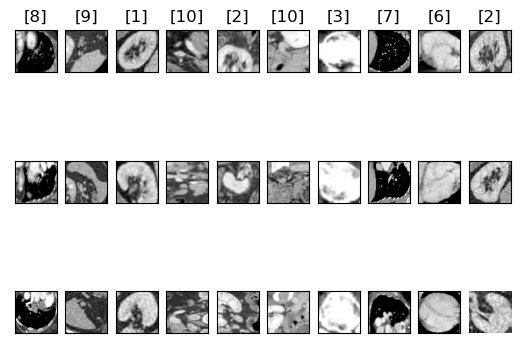

<Figure size 700x1500 with 0 Axes>

In [153]:
show_slice(train_dataset_, idx)

c:\Users\marus\anaconda3\lib\site-packages\medmnist\utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


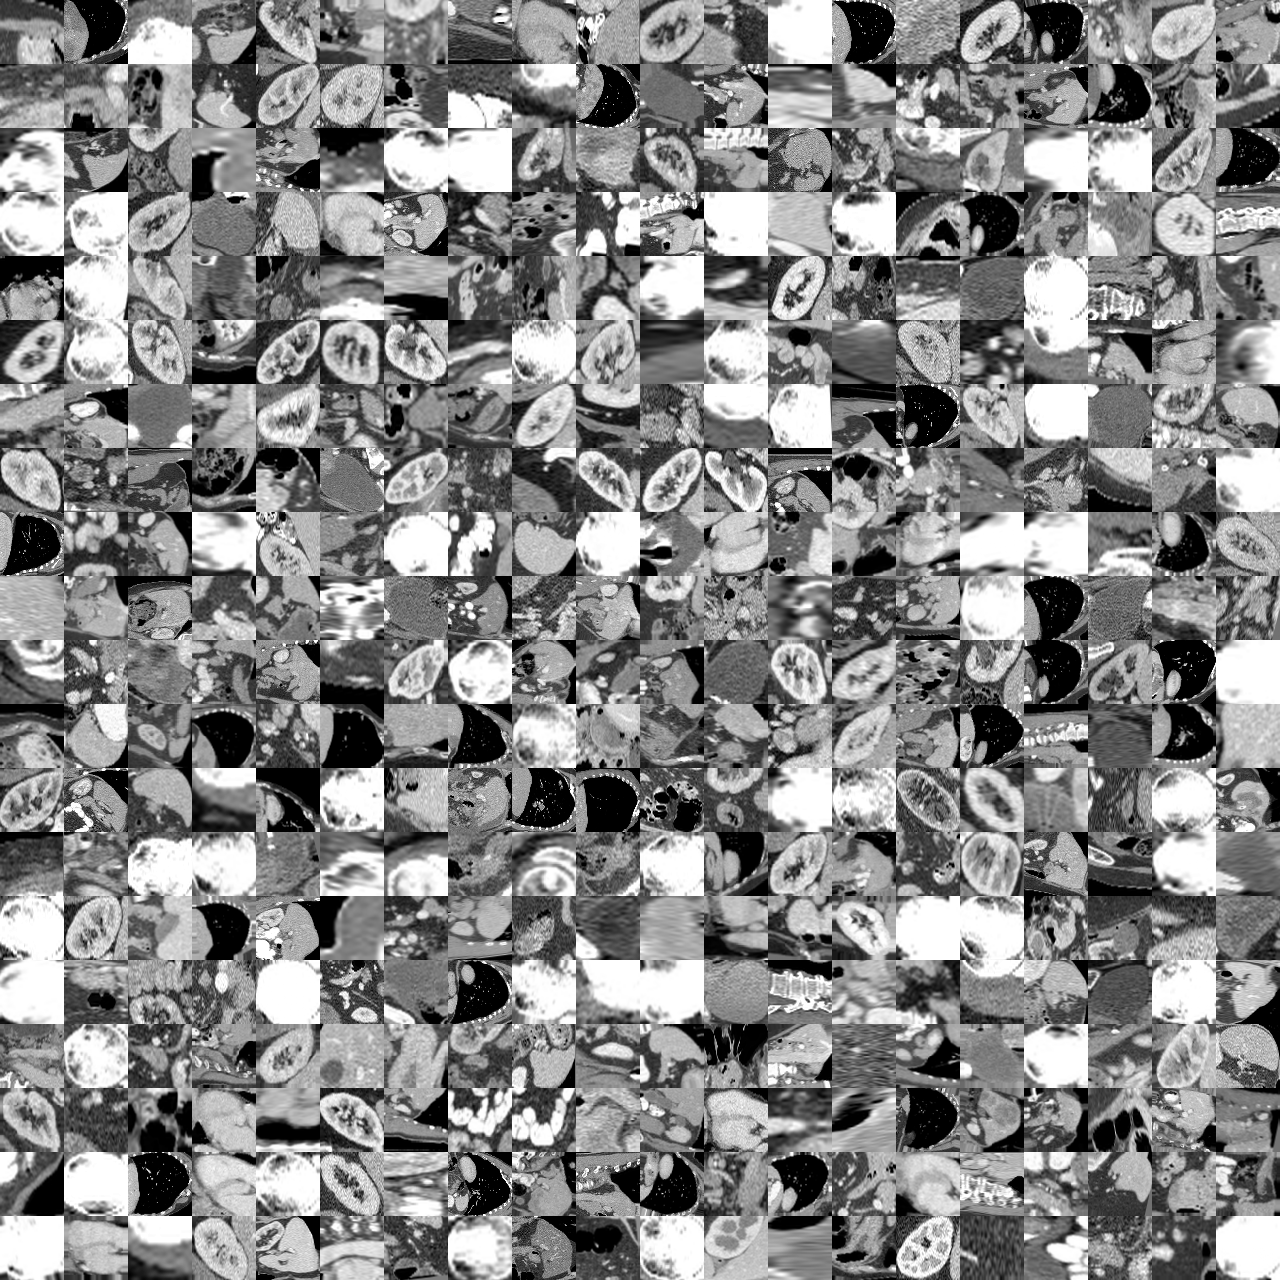

In [127]:
montage(train_dataset_, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset', flag = 'axial')

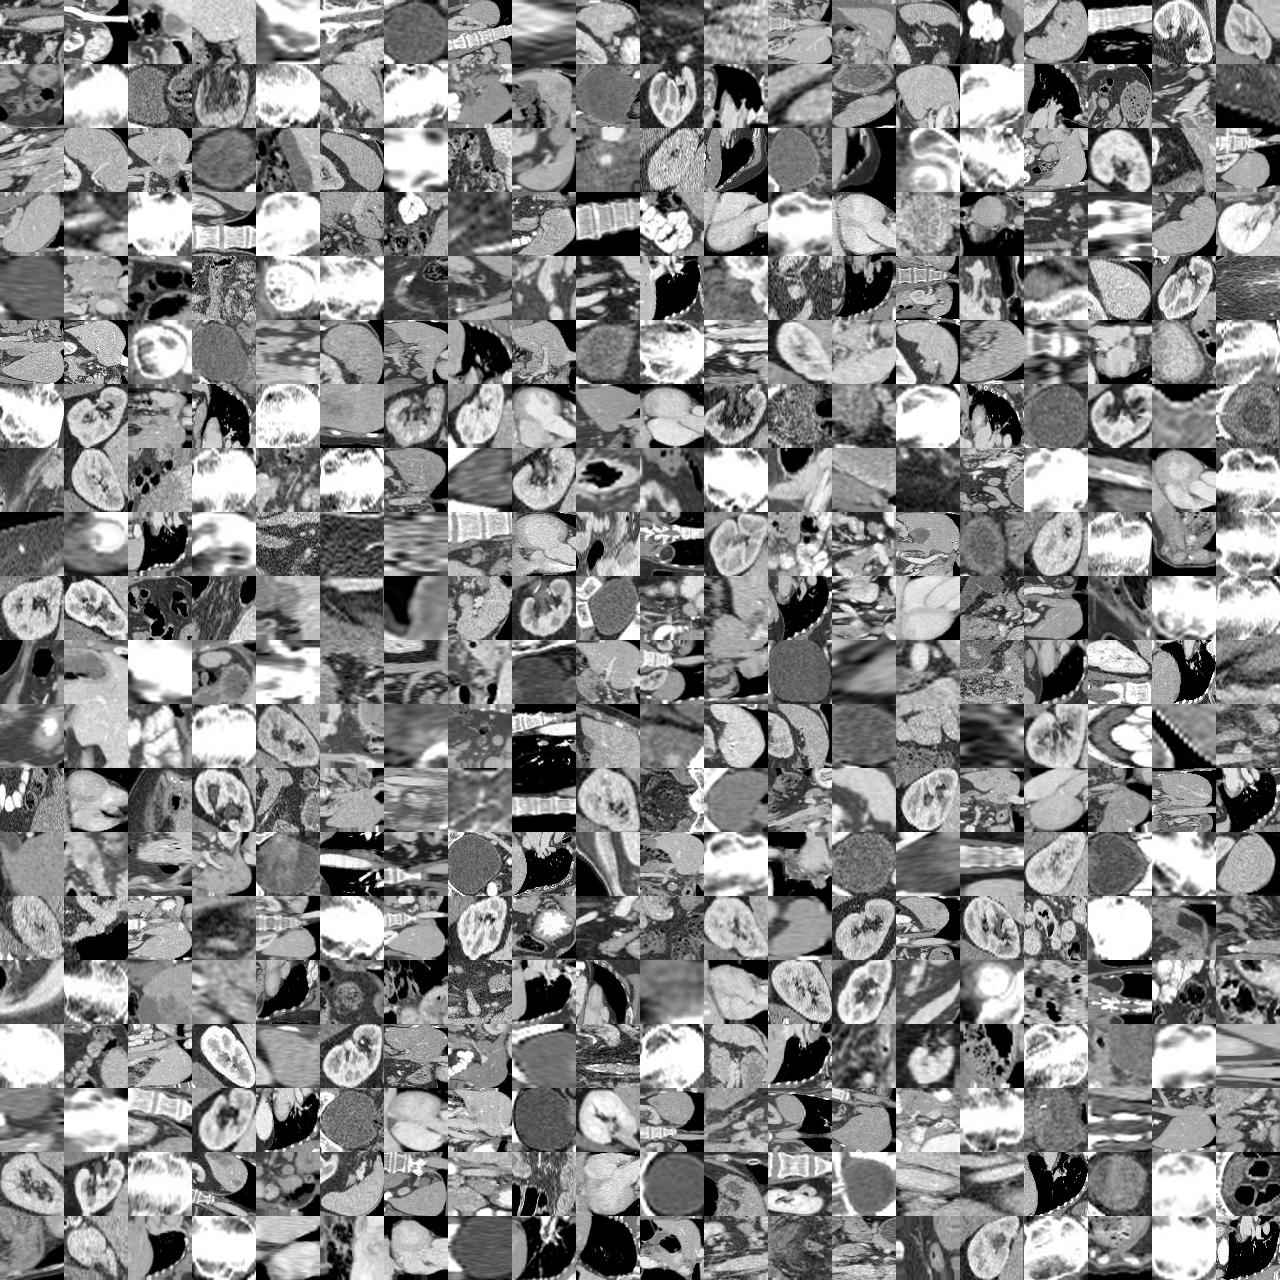

In [85]:
montage(train_dataset_, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset', flag = 'coronal')

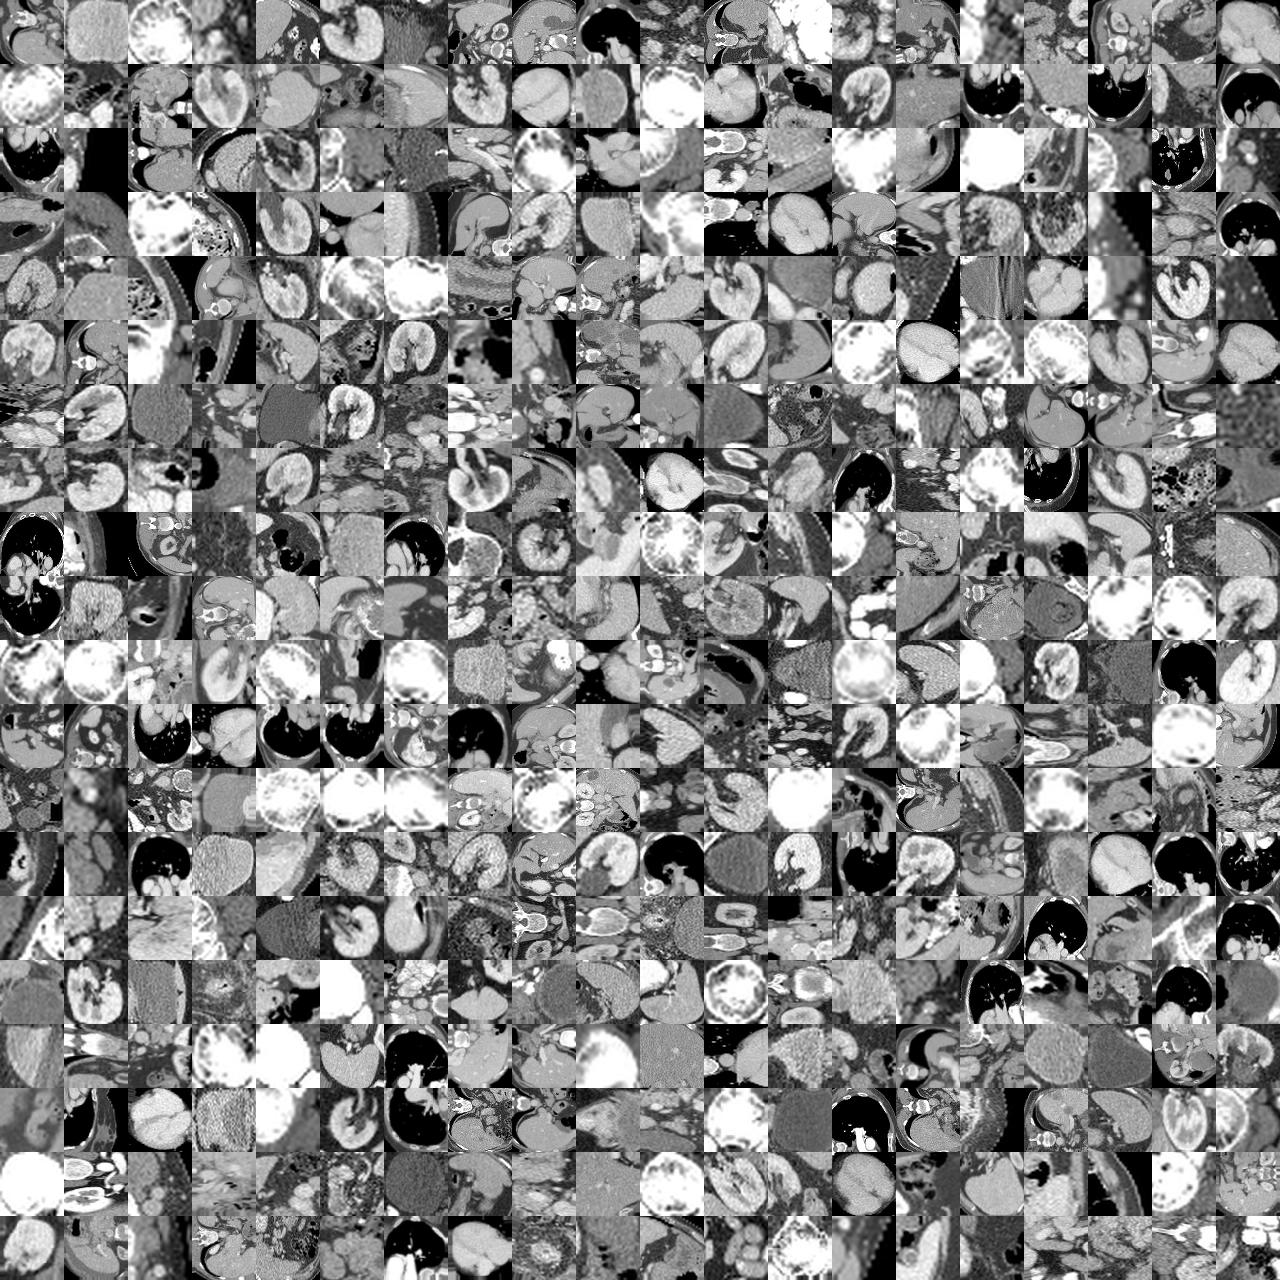

In [86]:
montage(train_dataset_, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset', flag = 'sagittal')

## Training cycle

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [94]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/7, train_loss: 2.6598
2/7, train_loss: 2.5099
3/7, train_loss: 2.4731
4/7, train_loss: 2.3230
5/7, train_loss: 2.4720
6/7, train_loss: 2.1555
7/7, train_loss: 2.0449
8/7, train_loss: 2.2233
epoch 1 average loss: 2.3577
1
saved new best metric model
current epoch: 1 current AUC: 0.6452 current accuracy: 0.0932 best AUC: 0.6452 at epoch: 1
----------
epoch 2/100
1/7, train_loss: 2.0563
2/7, train_loss: 1.9602
3/7, train_loss: 2.0440
4/7, train_loss: 1.8693
5/7, train_loss: 1.9021
6/7, train_loss: 1.7493
7/7, train_loss: 1.8592
8/7, train_loss: 1.8134
epoch 2 average loss: 1.9067
1
current epoch: 2 current AUC: 0.5997 current accuracy: 0.0932 best AUC: 0.6452 at epoch: 1
----------
epoch 3/100
1/7, train_loss: 1.7214
2/7, train_loss: 1.6464
3/7, train_loss: 1.7216
4/7, train_loss: 1.7640
5/7, train_loss: 1.5616
6/7, train_loss: 1.5170
7/7, train_loss: 1.6306
8/7, train_loss: 1.4901
epoch 3 average loss: 1.6316
1
current epoch: 3 current AUC: 0.6184 current accurac

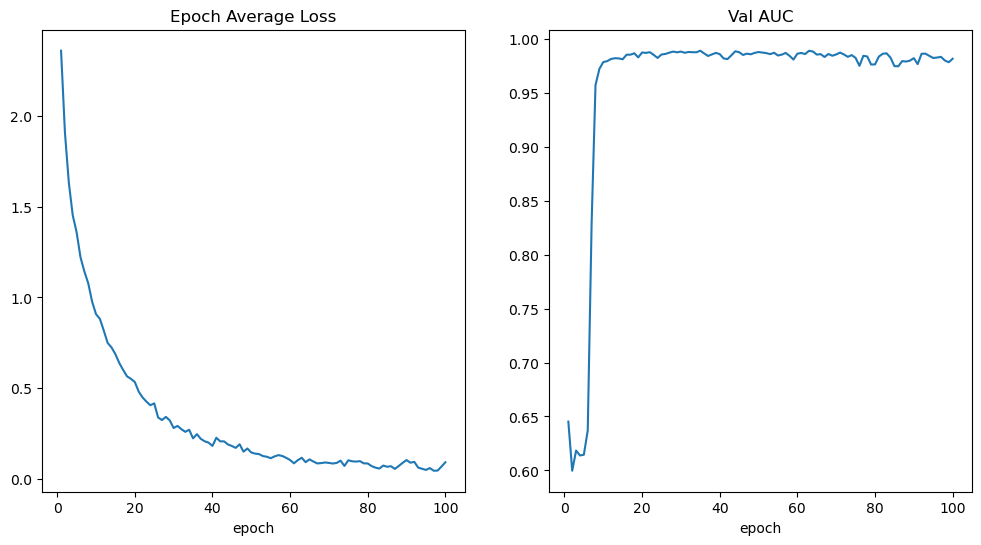

In [95]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

In [96]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

c:\Users\marus\anaconda3\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [97]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8873    0.9130    0.9000        69
           1     0.5056    0.6618    0.5732        68
           2     0.6923    0.5217    0.5950        69
           3     0.5376    0.7692    0.6329        65
           4     0.5926    0.2462    0.3478        65
           5     0.7297    0.8182    0.7714        66
           6     0.7000    0.7500    0.7241        28
           7     1.0000    0.9048    0.9500        21
           8     0.9130    1.0000    0.9545        21
           9     0.5976    0.7101    0.6490        69
          10     0.6400    0.4638    0.5378        69

    accuracy                         0.6656       610
   macro avg     0.7087    0.7053    0.6942       610
weighted avg     0.6724    0.6656    0.6540       610



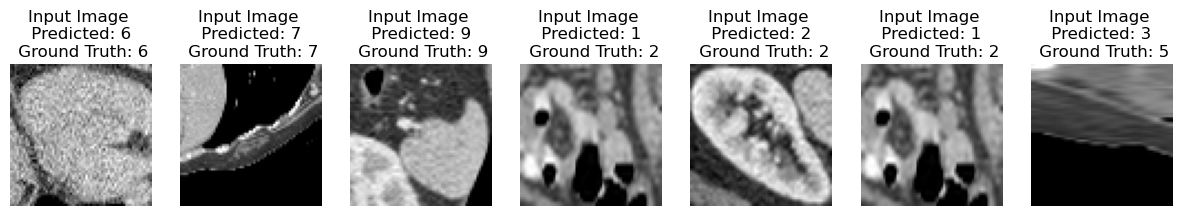

In [98]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, images.shape[0])
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(test_axial, pred, test_labels, n=7)

## Let's repeat the process for coronnal and sagittal parts of the dataset

## Training cycle for the coronal part

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [100]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/7, train_loss: 2.4361
2/7, train_loss: 2.3131
3/7, train_loss: 2.3095
4/7, train_loss: 2.2500
5/7, train_loss: 2.2196
6/7, train_loss: 2.1059
7/7, train_loss: 2.0421
8/7, train_loss: 2.0415
epoch 1 average loss: 2.2147
1
saved new best metric model
current epoch: 1 current AUC: 0.4929 current accuracy: 0.1801 best AUC: 0.4929 at epoch: 1
----------
epoch 2/100
1/7, train_loss: 1.9490
2/7, train_loss: 1.9658
3/7, train_loss: 1.8842
4/7, train_loss: 1.8326
5/7, train_loss: 1.8088
6/7, train_loss: 1.7404
7/7, train_loss: 1.6045
8/7, train_loss: 1.7031
epoch 2 average loss: 1.8111
1
saved new best metric model
current epoch: 2 current AUC: 0.5305 current accuracy: 0.0932 best AUC: 0.5305 at epoch: 2
----------
epoch 3/100
1/7, train_loss: 1.6609
2/7, train_loss: 1.5752
3/7, train_loss: 1.5362
4/7, train_loss: 1.5705
5/7, train_loss: 1.4321
6/7, train_loss: 1.5696
7/7, train_loss: 1.6189
8/7, train_loss: 1.3883
epoch 3 average loss: 1.5440
1
current epoch: 3 current

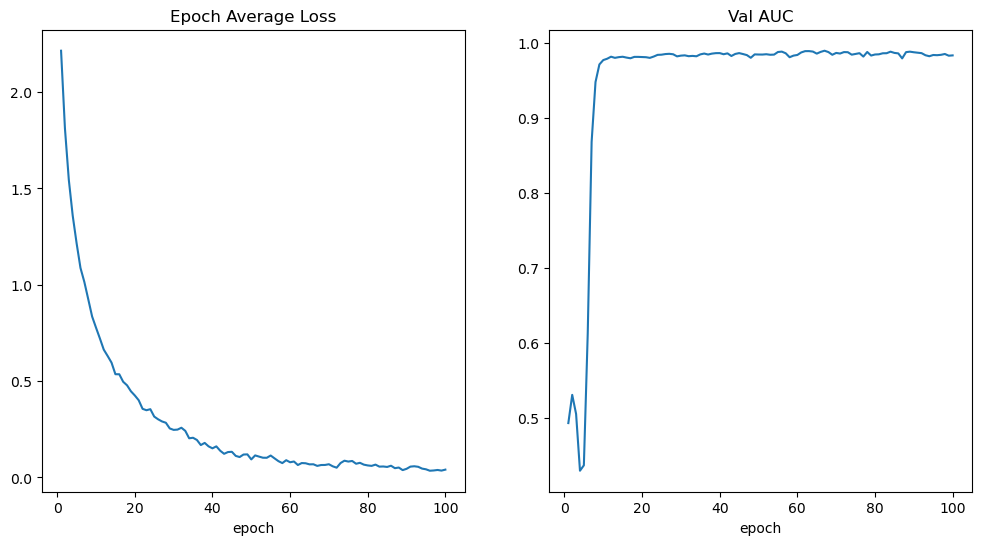

In [101]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

In [154]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

c:\Users\marus\anaconda3\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [155]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8333    0.9420    0.8844        69
           1     0.4691    0.5588    0.5101        68
           2     0.3875    0.4493    0.4161        69
           3     0.4824    0.6308    0.5467        65
           4     0.5111    0.3538    0.4182        65
           5     0.9565    0.6667    0.7857        66
           6     0.6875    0.3929    0.5000        28
           7     0.6176    1.0000    0.7636        21
           8     0.8571    0.2857    0.4286        21
           9     0.5568    0.7101    0.6242        69
          10     0.3600    0.2609    0.3025        69

    accuracy                         0.5689       610
   macro avg     0.6108    0.5683    0.5618       610
weighted avg     0.5858    0.5689    0.5606       610



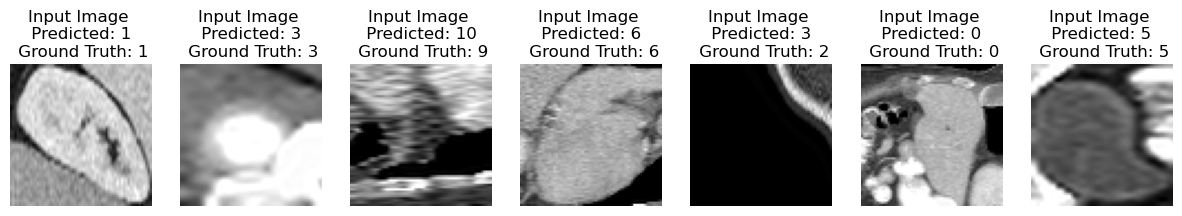

In [156]:
plot_examples(test_coronal, pred, test_labels, n=7)

## Training cycle for the sagittal part

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [107]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/7, train_loss: 2.4129
2/7, train_loss: 2.3946
3/7, train_loss: 2.3021
4/7, train_loss: 2.1543
5/7, train_loss: 2.1675
6/7, train_loss: 2.0470
7/7, train_loss: 2.0163
8/7, train_loss: 1.8917
epoch 1 average loss: 2.1733
1
saved new best metric model
current epoch: 1 current AUC: 0.4836 current accuracy: 0.0932 best AUC: 0.4836 at epoch: 1
----------
epoch 2/100
1/7, train_loss: 1.8654
2/7, train_loss: 1.8844
3/7, train_loss: 1.8643
4/7, train_loss: 1.7773
5/7, train_loss: 1.8078
6/7, train_loss: 1.7384
7/7, train_loss: 1.8110
8/7, train_loss: 1.7036
epoch 2 average loss: 1.8065
1
current epoch: 2 current AUC: 0.4451 current accuracy: 0.0932 best AUC: 0.4836 at epoch: 1
----------
epoch 3/100
1/7, train_loss: 1.8125
2/7, train_loss: 1.6050
3/7, train_loss: 1.7191
4/7, train_loss: 1.6012
5/7, train_loss: 1.6248
6/7, train_loss: 1.5950
7/7, train_loss: 1.5091
8/7, train_loss: 1.5043
epoch 3 average loss: 1.6214
1
saved new best metric model
current epoch: 3 current

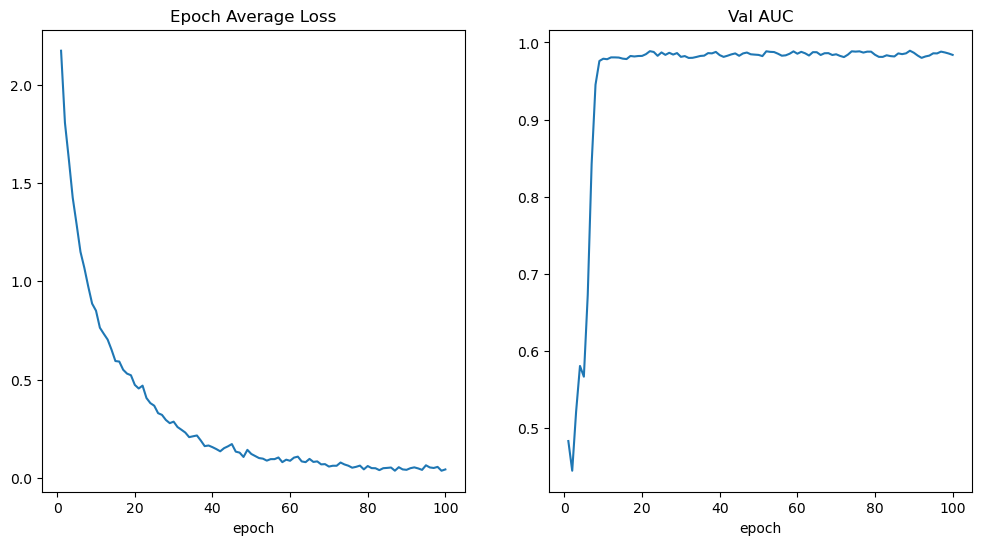

In [108]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

In [109]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

c:\Users\marus\anaconda3\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [110]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.5000    0.3913    0.4390        69
           1     0.2615    0.2500    0.2556        68
           2     0.2656    0.2464    0.2556        69
           3     0.4182    0.3538    0.3833        65
           4     0.4681    0.3385    0.3929        65
           5     0.6545    0.5455    0.5950        66
           6     0.2727    0.2143    0.2400        28
           7     0.4737    0.4286    0.4500        21
           8     0.2941    0.2381    0.2632        21
           9     0.3163    0.4493    0.3713        69
          10     0.2895    0.4783    0.3607        69

    accuracy                         0.3705       610
   macro avg     0.3831    0.3576    0.3642       610
weighted avg     0.3885    0.3705    0.3725       610



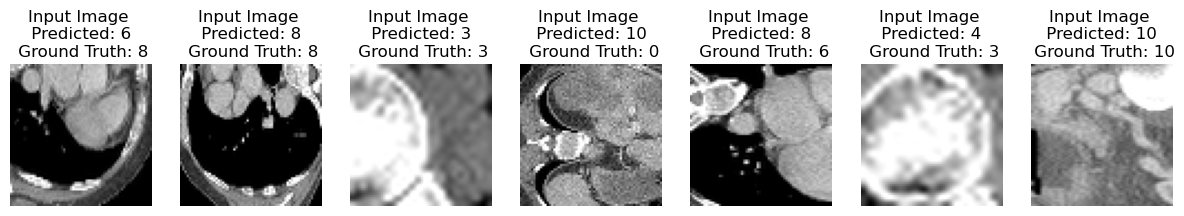

In [111]:
plot_examples(test_sagittal, pred, test_labels, n=7)